Granulometric Filter
=================
An implementration of the Granulometric Filter in Python. See https://imagej.net/Granulometric_Filtering.

In [1]:
import numpy as np
import numpy.fft as fft
import random as r
import scipy.cluster.vq as clust
import scipy.signal as sgnl
import scipy.ndimage as ndi
import skimage.io as io
import skimage.filters as fltrs
import skimage.feature as ftr
import matplotlib.pylab as plt
from skimage.util import random_noise
plt.gray()

<Figure size 432x288 with 0 Axes>

## Sythetic Image Creation

In [2]:
'''
Synthetic circle image creator function

imx: x size of image
imy: y size of image
amt: amount of cirles in image; default = 20
rmax: max radius of circles created

returns: nparray of image
'''
def syn_circle_img(imx=500, imy=500, amt=20, rmax=35):
    im = np.zeros((imx,imy))
    for _ in range(amt):
        cx = r.randint(0,imx)
        cy = r.randint(0,imy)
        cr = r.randint(5, rmax)
        print(cx, cy, cr)
        x,y = np.meshgrid(np.arange(im.shape[0]), np.arange(im.shape[1]))
        dist = np.sqrt((x - cx) ** 2 + (y - cy) ** 2)
        im[np.where(dist < cr)] = 1
    return im.astype(np.bool)

167 431 22
239 131 13
159 401 7
155 28 34
273 199 13
380 325 20
73 168 15
187 148 29
405 87 18
3 326 33
388 296 28
221 488 17
403 376 18
463 402 16
11 294 28
62 27 16
405 472 26
171 113 19
436 305 28
404 298 10


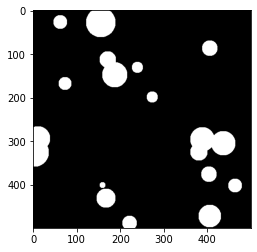

In [3]:
#rerun this cell to change image
im = syn_circle_img()
plt.imshow(im)
# binary = im < fltrs.threshold_otsu(im)

1) Perform granulometry of the image and compute G(d)
$$V[S]=\sum_{g=0}^{255} H(g)\times g \;\textrm{(H is histogram of image)}$$
$$G(d)=\frac{V[S\circ dE]-V[S\circ(d-1)E]}{V[S]}$$

2) Identify the scale of interest by the pattern of the peaks in G(d); select low bound $I_{\textrm{low}}=S\circ E_{\textrm{low}}$ and high bound images $I_{\textrm{high}}=S\circ E_{\textrm{high}}$ and subtract the images $(I_{\textrm{high}}-I_{\textrm{low}})$

 

## Granulometric Filter Function

In [78]:
def G(im, struct, d):
    open_d1 = ndi.binary_opening(im, (d - 1)*struct)
    open_d = ndi.binary_opening(im, d * struct)

    v_max = open_d.sum()
    v_min = open_d1.sum()
    v = im.sum()
    return (v_max & (~v_min)) / v

def granulometry(S, E, d):
    for i in range(1, d+1):
        S = S | ndi.binary_opening(S, d*E)
    return S

def step_struct(struct, step):
    '''Dilates a struct step times for granulometric filtering'''
    # Dilate struct step times
    for i in range(step):
        # If struct has values on the edge, expand it so that values of the dilation are not truncated
        if (struct[0]+struct[-1]).sum() + (struct[:,0]+struct[:,-1]).sum() > 0:
            struct = np.pad(struct, 1)
        struct = ndi.binary_dilation(struct, struct)
    return struct

def granulometric_filter(im, struct=None, radius=9, step=1, d=35):
    '''
        im: a grayscale image
        struct: a structure for mathematical morphological computations
        radius: the smallest radius of the expected particles
        step: the step to add to radius for the largest radius of the expected particles
        retsult: image with filter applied
    '''
    # TODO: Step 1
    if struct is None or isinstance(struct, str):
        if struct == 'full':
            struct = ndi.generate_binary_structure(2, 2)
        else: # default is plus so struct == 'plus' falls into this block
        
        
            struct = ndi.generate_binary_structure(2, 1)
        struct_min = step_struct(struct, radius - 1) # Step struct to radius size; technically radius + 0.5
    struct_max = step_struct(struct, step)
    
    # Compute granulometry
    gran = granulometry(im, struct_min, d)

    # Compute G(d) 
    Gs = []
    for d in range(0,36):
        Gs.append(G(im, struct, d))
    print(Gs)

    # TODO: Step 2
    I_low = ndi.binary_opening(im, struct_min)
    I_high = ndi.binary_opening(im, struct_max)
    diff = I_low & (~I_high)

    return gran

In [85]:
plt.figure()
# im = io.imread('pebbles_grayscale.png')
# binary = im < fltrs.threshold_otsu(im)
out = granulometric_filter(im, radius=15, step=5)
plt.subplot(121)
plt.imshow(im)
plt.subplot(122)
plt.imshow(out, cmap='cool')
plt.colorbar()
